I have another notebook where I examine data and explore various options.  
However, that takes a while to run and is full of extraneous information.
Here I distill everything down to a working example that I would like to submit...

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
file_path = '/kaggle/input/abalone/train.csv'
train_df = pd.read_csv(file_path)

In [3]:
# One-hot encode 'Sex'
train_df = pd.get_dummies(train_df, columns=['Sex'], drop_first=True)

# View the updated dataset
print(train_df.head())

   id  Length  Diameter  Height  Whole weight  Whole weight.1  Whole weight.2  \
0   0   0.550     0.430   0.150        0.7715          0.3285          0.1465   
1   1   0.630     0.490   0.145        1.1300          0.4580          0.2765   
2   2   0.160     0.110   0.025        0.0210          0.0055          0.0030   
3   3   0.595     0.475   0.150        0.9145          0.3755          0.2055   
4   4   0.555     0.425   0.130        0.7820          0.3695          0.1600   

   Shell weight  Rings  Sex_I  Sex_M  
0        0.2400     11  False  False  
1        0.3200     11  False  False  
2        0.0050      6   True  False  
3        0.2500     10  False   True  
4        0.1975      9   True  False  


In [4]:
# Retain only selected features
selected_features = ['Shell weight', 'Height', 'Diameter', 'Whole weight', 'Rings', 'Sex_I', 'Sex_M']
train_df_selected = train_df[selected_features]

# Confirm the updated dataset
print(train_df_selected.head())

   Shell weight  Height  Diameter  Whole weight  Rings  Sex_I  Sex_M
0        0.2400   0.150     0.430        0.7715     11  False  False
1        0.3200   0.145     0.490        1.1300     11  False  False
2        0.0050   0.025     0.110        0.0210      6   True  False
3        0.2500   0.150     0.475        0.9145     10  False   True
4        0.1975   0.130     0.425        0.7820      9   True  False


In [5]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = train_df_selected.drop(columns=['Rings'])  # Features
y = train_df_selected['Rings']                # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirm the split
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (72492, 6)
Testing set size: (18123, 6)


Now prep the final test data in the same way

Note that as this solution uses forests (and not linear regression) there is no value in using StandardScaler to scale data...

In [6]:
# Read the test data
submission = pd.read_csv('/kaggle/input/abalone/test.csv')

# One-hot encode 'Sex'
submission_df = pd.get_dummies(submission, columns=['Sex'], drop_first=True)

submission_df.head()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Sex_I,Sex_M
0,90615,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,False,True
1,90616,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,False,True
2,90617,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,False,True
3,90618,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,False,True
4,90619,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,True,False


In [7]:
test_selected_features = ['Shell weight', 'Height', 'Diameter', 'Whole weight', 'Sex_I', 'Sex_M']

submission_selected = submission_df[test_selected_features]

#submission_scaled = submission_selected.copy()
#submission_scaled[numerical_features] = scaler.transform(submission_df[numerical_features])

submission_selected.head()

,Shell weight,Height,Diameter,Whole weight,Sex_I,Sex_M
0,0.3005,0.155,0.475,1.2380,False,True
1,0.2750,0.160,0.460,0.9830,False,True
2,0.2405,0.140,0.420,0.8395,False,True
3,0.2350,0.145,0.490,0.8740,False,True
4,0.1050,0.110,0.325,0.3580,True,False


An attempt at an ensemble model, based upon https://www.kaggle.com/code/kqyan1990/abalone-prediction-a-complete-notebook

In [8]:
def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [9]:
def evaluate_model(true, predicted):
    # mae = mean_absolute_error(true, predicted)
    # mse = mean_squared_error(true, predicted)
    # rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    rmsle = root_mean_squared_log_error(true, predicted)
    return r2_square,rmsle 

In [10]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet,Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import  AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error


In [11]:
# create a utility function to sort the dictionary by values aphabatically
def sort_dict(d):
    return dict(sorted(d.items(), key=lambda x: x[0]))

# Define a list of models for prediction
models = {
    "Linear Regression": LinearRegression(),
    #"Lasso": Lasso(),
    #"SVR": SVR(),
    #"K-Neighbors Regressor": KNeighborsRegressor(),
    #"Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    #"Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Extra Trees Regressor": ExtraTreesRegressor(),
    #"XGBRegressor": XGBRegressor(), 
    #"CatBoosting Regressor": CatBoostRegressor(verbose=False),
    #"AdaBoost Regressor": AdaBoostRegressor(),
    #"LightGBM": lgb.LGBMRegressor(),
    'DummyRegressor': DummyRegressor(strategy='mean') # DummyRegressor is added for sanity check
}

# Sort the models
models=sort_dict(models)

In [12]:
# Define the parameters for the hyperparamter tuning of models by RandomizedSearchCV
import scipy.stats as stats
params={

    # "Decision Tree":{
    #       'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    #       # 'splitter':['best','random'],
    #       # 'max_features':['sqrt','log2'],  
    # },
     
     "Random Forest Regressor":{
         # 'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
         # 'max_features':['sqrt','log2',None],
         'n_estimators': [8,16,32,64,128,256]
     },

                    
    #  "Gradient Boosting":{
    #       # 'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
    #       'learning_rate':[.1,.01,.05,.001],
    #       'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
    #       # 'criterion':['squared_error', 'friedman_mse'],
    #       # 'max_features':['auto','sqrt','log2'],
    #       'n_estimators': [8,16,32,64,128,256]
    #  },

     "Linear Regression":{},

     "XGBRegressor":{
        'booster': ['gbtree','dart'],
        'reg_alpha': stats.uniform(0, 1),
        'learning_rate':stats.loguniform(1e-2, 1e-1),
        'n_estimators': [8,16,32,64,128,256]
     },

     "CatBoosting Regressor":{
         'depth': [6,8,10],
          'learning_rate': stats.loguniform(1e-2, 1e-1),
          'iterations': [30, 50, 100]
     },

    #  "AdaBoost Regressor":{
    #       'learning_rate':[.1,.01,0.5,.001],
    #       # 'loss':['linear','square','exponential'],
    #       'n_estimators': [8,16,32,64,128,256]
    #  },
            
     "Extra Trees Regressor":{
          # 'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
          # 'max_features':['sqrt','log2',None],
          'n_estimators': [8,16,32,64,128,256]
     },

    #  "K-Neighbors Regressor":{
    #     'n_neighbors': [3,5,7,9],
    #     'weights': ['uniform','distance'],
    #     'algorithm': ['auto','ball_tree','kd_tree','brute']
    # },
                
    # "Lasso":{
    #     'alpha': [0.1,0.5,1.0,1.5],
    #     'selection': ['cyclic','random']
    # },

    # "SVR":{
    #     'kernel': ['linear','poly','rbf','sigmoid'],
    #     'C': [0.1,1,10,100,1000],
    #     'gamma': ['scale','auto']
    # },

    "DummyRegressor":{}

}

# Sort the parameters
params = sort_dict(params)

In [13]:
from sklearn.metrics import make_scorer

# Define a custom cost function for the RandomizedSearchCV
def rmsle(y_true, y_pred):
    rmsle= root_mean_squared_log_error(y_true, y_pred)
    return rmsle

In [14]:
from time import time
# Define a function for initiating empty lists for storing the model parameters and the scores
def model_evaluation(models, params, X_train, y_train, X_test, y_test, kf):
    model_list = []
    r2_train_list =[]
    r2_test_list = []
    rmsle_train_list =[]
    rmsle_test_list = []
    time_list =[]
    y_train_pred_list=[]
    model_params = []

    for i in range(len(list(models))):
        try:
            model = list(models.values())[i]
            para=params[list(models.keys())[i]]
            # implement a nested cross-validation
            start=time()
            RS = RandomizedSearchCV(model, para, n_iter=10, cv=kf, scoring=make_scorer(rmsle, greater_is_better=False),refit=True, n_jobs=-1, verbose=1)
            RS.fit(X_train, y_train) # Train model
            time_list.append(time()-start)
            model.set_params(**RS.best_params_)
            model.fit(X_train, y_train)

            # Make predictions
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
        
            # Evaluate Train and Test dataset
            r2_train, rmsle_train = evaluate_model(y_train, y_train_pred)

            r2_test, rmsle_test = evaluate_model(y_test, y_test_pred)

            # Append the results to the lists     
            model_list.append(list(models.keys())[i])
            r2_train_list.append(r2_train)
            r2_test_list.append(r2_test)
            rmsle_train_list.append(rmsle_train)
            rmsle_test_list.append(rmsle_test)
            y_train_pred_list.append(y_train_pred)
            # Append the model parameters
            model_params.append(RS.best_params_)

            print('Model Success:',list(models.keys())[i], 'R2:', r2_test, 'RMSLE:', rmsle_test)
            print('='*35)
            print('\n')

            # Print the best hyperparameters
            print('Best hyperparameters:',  RS.best_params_)

        # Raise exception if the model fails
        except Exception as e:
            print(list(models.keys())[i])
            model_list.append(list(models.keys())[i])
            r2_train_list.append(np.nan)
            r2_test_list.append(np.nan)
            rmsle_train_list.append(np.nan)
            rmsle_test_list.append(np.nan)
            print('Model failed:', e)
            print('='*35)
            print('\n')
            continue

    return model_list, r2_train_list, r2_test_list, rmsle_train_list, rmsle_test_list, time_list, y_train_pred_list,model_params

In [15]:
from sklearn.model_selection import KFold
SEED=0
# Setup the KFold
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS,shuffle=True, random_state=SEED)

Catboost failure: https://stackoverflow.com/questions/68950922/unable-to-tune-hyperparameters-for-catboostregressor

In [16]:
# Scores with feature engineered data
model_list, r2_train_list, r2_test_list, rmsle_train_list, rmsle_test_list, time_list,y_train_pred_list, model_params= model_evaluation(models, params, X_train, y_train, X_test, y_test, kf)

# Display the scores
pd.DataFrame(list(zip(model_list,time_list, r2_train_list,r2_test_list,rmsle_train_list,rmsle_test_list)), columns=['Model Name','Compute time', 'r2_Score_Train','r2_Score_test','RMSLE_Score_Train','RMSLE_Score_Test']).sort_values(by=["RMSLE_Score_Train"],ascending=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model Success: DummyRegressor R2: -2.4498836381781075e-07 RMSLE: 0.29094884304084784


Best hyperparameters: {}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model Success: Extra Trees Regressor R2: 0.5403975199721549 RMSLE: 0.1777238045579696


Best hyperparameters: {'n_estimators': 256}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model Success: Linear Regression R2: 0.546040614328724 RMSLE: 0.17421514122468837


Best hyperparameters: {}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model Success: Random Forest Regressor R2: 0.5695148548438786 RMSLE: 0.1716518904297276


Best hyperparameters: {'n_estimators': 256}


,Model Name,Compute time,r2_Score_Train,r2_Score_test,RMSLE_Score_Train,RMSLE_Score_Test
1,Extra Trees Regressor,147.185370,0.993644,5.403975e-01,0.026308,0.177724
3,Random Forest Regressor,242.364270,0.936799,5.695149e-01,0.067609,0.171652
2,Linear Regression,0.416968,0.554631,5.460406e-01,0.170800,0.174215
0,DummyRegressor,2.080455,0.000000,-2.449884e-07,0.287829,0.290949


The XGBRegressor takes far longer to get slightly better test results.  Note that some of the other methods seem to overfit and get better training results.

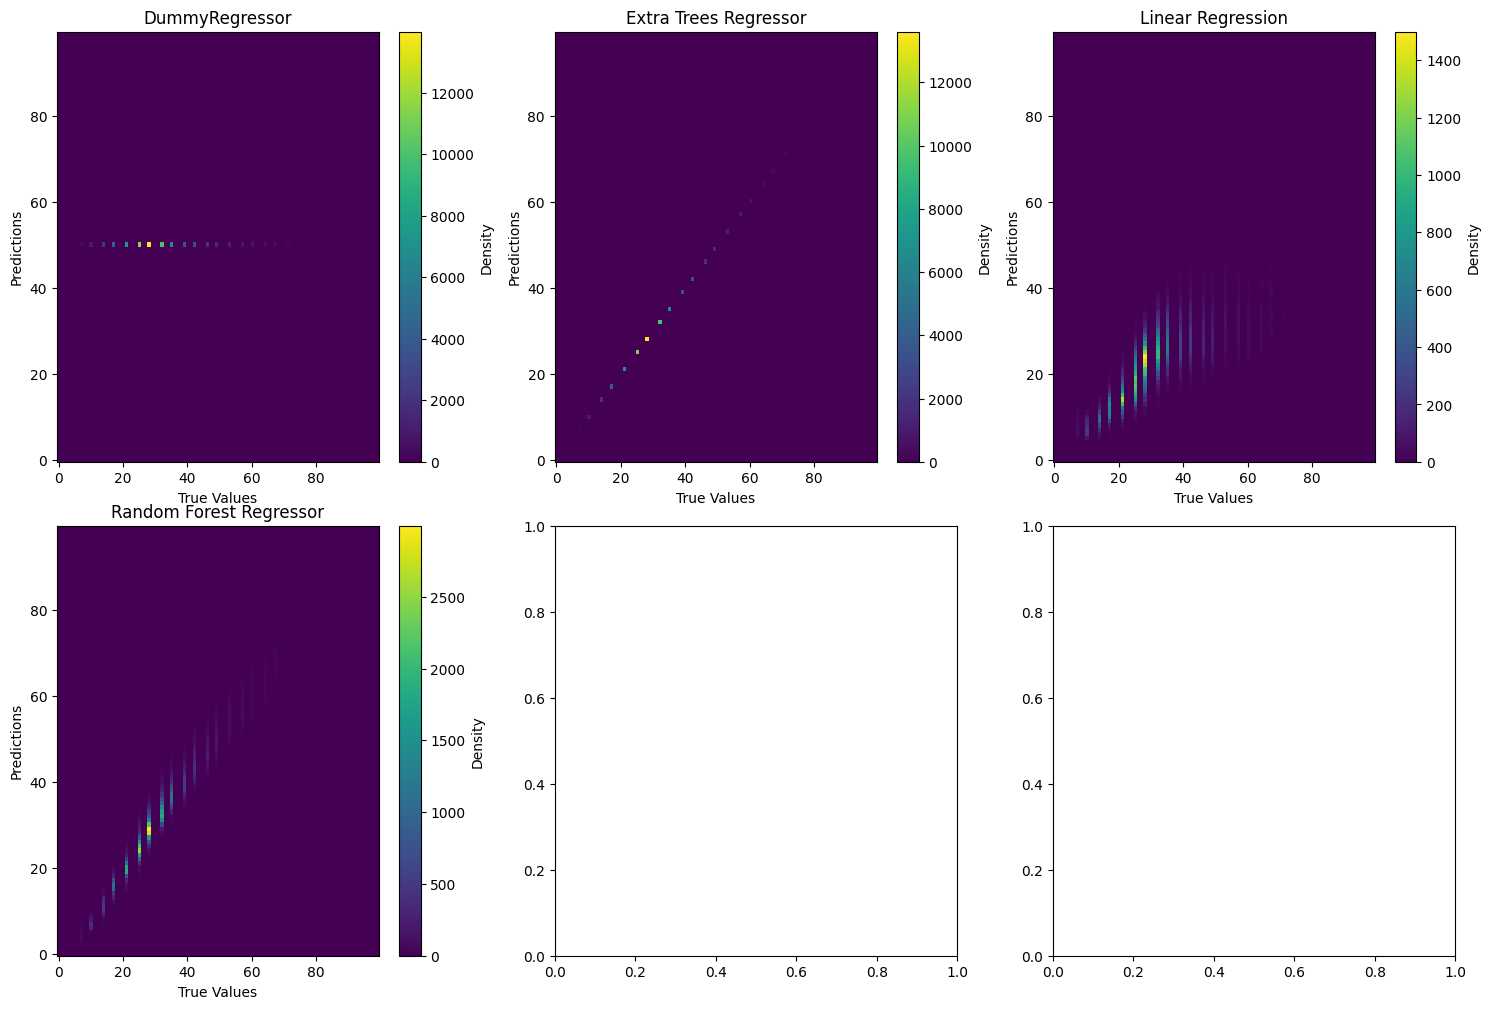

In [17]:
# Plot the y_train and y_train_pred 
f_cols=3
f_rows = np.ceil(len(list(models))/f_cols).astype(int)
fig, ax = plt.subplots(f_rows, f_cols, figsize=(15, 10))
for i in range(len(y_train_pred_list)):
    plt.tight_layout()
    heatmap, xedges, yedges = np.histogram2d(x=y_train, y=y_train_pred_list[i].tolist(), bins=100)
    cax=ax[i//f_cols, i%f_cols].imshow(heatmap.T, origin='lower', cmap='viridis', aspect='auto')
    ax[i//f_cols, i%f_cols].set_xlabel('True Values')
    ax[i//f_cols, i%f_cols].set_ylabel('Predictions')
    ax[i//f_cols, i%f_cols].grid(False) 
    fig.colorbar(cax, ax=ax[i//f_cols, i%f_cols], label='Density')
    ax[i//f_cols, i%f_cols].set_title(list(models.keys())[i])


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


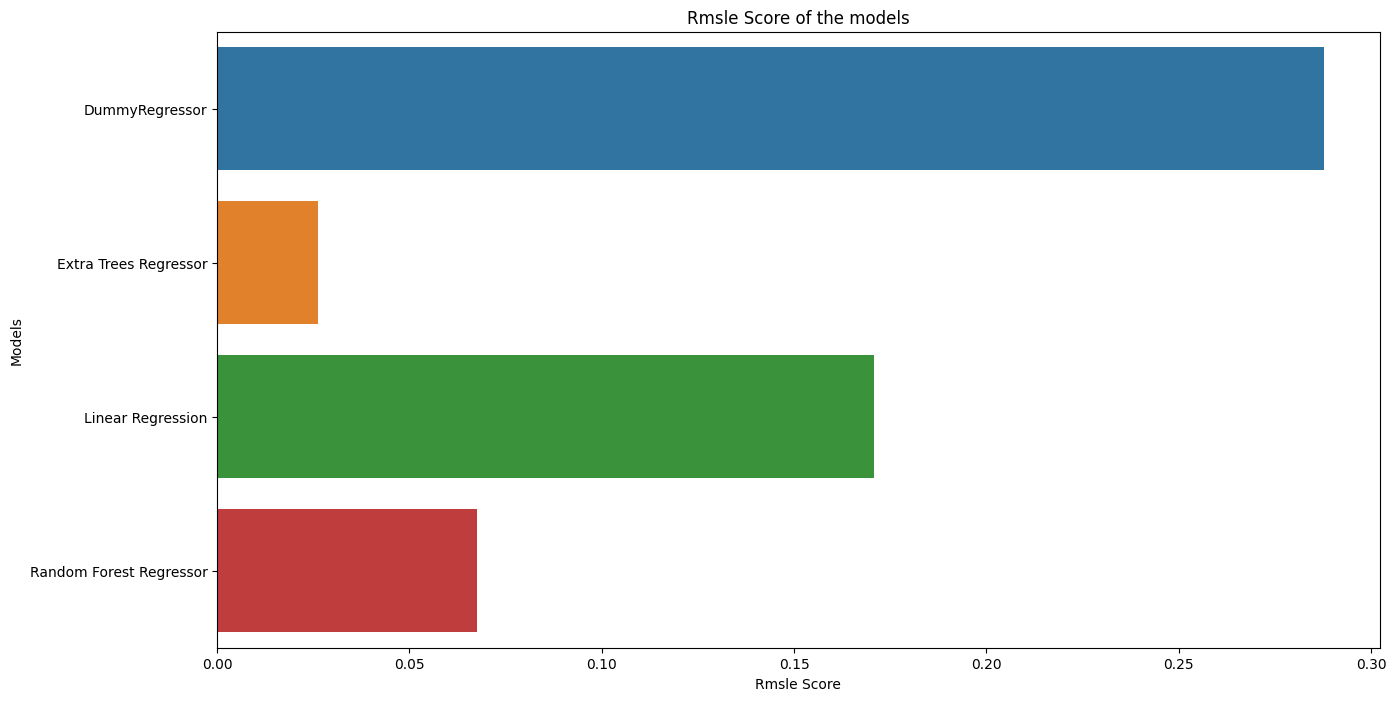

In [18]:
# Plot the RMSLE score of the models and sort them in descending order
plt.figure(figsize=(15, 8))
sns.barplot(x=rmsle_train_list, y=model_list)
plt.title('Rmsle Score of the models')
plt.xlabel('Rmsle Score')
plt.ylabel('Models')
plt.show()

Not sure why the source I am working from using the training results.  These test results are more likely to be useful...

Really interesting to compare the results to see which methods generalize better.

## Ensemble

Now to try an ensemble...

Based off of this example: https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python

In [24]:
# Define a function to obtain the out of fold predictions
def get_oof_predictions(model, X_train, y_train, X_test, kf):
    X_train_ri = X_train.reset_index()
    y_train_ri = y_train.reset_index()
    
    # Initialize the out of fold predictions
    oof_predictions = np.zeros((X_train.shape[0],2))
    # Initialize the test predictions
    test_predictions = np.zeros((X_test.shape[0],2))

    # Loop through the training and validation sets
    for train_index, val_index in kf.split(X_train):
        # Split the training and validation sets
        print("X_train_ri index", X_train_ri.index)
        X_tr, X_val = X_train_ri.iloc[train_index], X_train_ri.iloc[val_index]
        y_tr, y_val = y_train_ri.iloc[train_index], y_train_ri.iloc[val_index]
        # Fit the model
        #model.fit(X_tr, y_tr) # is this necessary?
        # Make predictions
        print (oof_predictions[val_index].shape)
        oof_predictions[val_index] = model.predict(X_val)
        test_predictions += model.predict(X_test)

    # Return the out of fold predictions and the test predictions
    return oof_predictions, test_predictions / kf.get_n_splits() # Average the test predictions

In [21]:
X_train

,Shell weight,Height,Diameter,Whole weight,Sex_I,Sex_M
43718,0.360,0.175,0.505,1.3850,False,True
45247,0.385,0.195,0.520,1.5405,False,False
71393,0.285,0.150,0.495,1.1345,False,True
51688,0.440,0.200,0.560,1.5340,False,True
40681,0.038,0.075,0.200,0.1075,True,False
...,...,...,...,...,...,...
6265,0.055,0.080,0.265,0.1790,True,False
54886,0.225,0.140,0.460,0.8435,False,False
76820,0.170,0.125,0.420,0.5965,True,False
860,0.499,0.185,0.525,1.8275,False,True


In [22]:
X_test

,Shell weight,Height,Diameter,Whole weight,Sex_I,Sex_M
3502,0.1550,0.125,0.380,0.5290,True,False
76031,0.1025,0.100,0.345,0.3705,True,False
49473,0.2350,0.135,0.440,0.7390,False,True
16126,0.1900,0.140,0.410,0.7090,False,False
65405,0.3100,0.150,0.455,1.0590,False,False
...,...,...,...,...,...,...
71483,0.2405,0.125,0.415,0.8020,False,True
76423,0.2715,0.135,0.435,0.9745,False,True
67841,0.1550,0.115,0.350,0.4960,False,False
36518,0.3745,0.175,0.505,1.3080,False,True


In [23]:
y_train

43718    10
45247    11
71393     9
51688    11
40681     5
         ..
6265      7
54886     9
76820     8
860      11
15795     7
Name: Rings, Length: 72492, dtype: int64

In [25]:
# Initialize a dataframe of out of fold predictions for the models
oof_predictions_df = pd.DataFrame()
# Initialize a dataframe of test predictions for the models
test_predictions_df = pd.DataFrame()

# Get the out of fold predictions from the models
for i in range(len(list(models))):
    model = list(models.values())[i]
    oof_predictions, test_predictions = get_oof_predictions(model, X_train, y_train, X_test, kf)
    print(oof_predictions.shape)
    oof_predictions_df[list(models.keys())[i]] = oof_predictions[1]
    test_predictions_df[list(models.keys())[i]] = test_predictions[1]

# Display the out of fold predictions
oof_predictions_df

X_train_ri index RangeIndex(start=0, stop=72492, step=1)
(14499, 2)
X_train_ri index RangeIndex(start=0, stop=72492, step=1)
(14499, 2)
X_train_ri index RangeIndex(start=0, stop=72492, step=1)
(14498, 2)
X_train_ri index RangeIndex(start=0, stop=72492, step=1)
(14498, 2)
X_train_ri index RangeIndex(start=0, stop=72492, step=1)
(14498, 2)
(72492, 2)
X_train_ri index RangeIndex(start=0, stop=72492, step=1)
(14499, 2)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- index


In [ ]:
print(list(models.keys())[0])

In [ ]:
# Plot the out of fold predictions in the same figure
plt.figure(figsize=(10, 6))
for i in range(len(list(models))):
    sns.scatterplot(x=y_train, y=oof_predictions_df[list(models.keys())[i]], label=list(models.keys())[i])
# Plot the identity line
plt.plot([0, 30], [0, 30], color='black', linestyle='--')
plt.legend()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Out of Fold Predictions')

In [ ]:
# Extract the feature importances from the models
feature_importances = pd.DataFrame()
for i in range(len(list(models))):
    model = list(models.values())[i]
    try:
        feature_importances[list(models.keys())[i]] = model.feature_importances_
    except AttributeError:
        feature_importances[list(models.keys())[i]] = np.nan

# Display the feature importances
feature_importances

In [ ]:
# plot the correlation matrix of the out of fold predictions
plt.figure(figsize=(15, 10))
sns.heatmap(oof_predictions_df_selected.corr(), annot=True, fmt=".2f", linewidths=0.5, cmap='coolwarm', square=True, cbar_kws={"shrink": 0.5})
plt.title('Correlation Plot of the Out of Fold Predictions', fontsize=22)
plt.tight_layout()
plt.show()

In [ ]:
# Create a dataframe to store the OOF predictions from selected models
oof_predictions_df_selected = pd.DataFrame()
oof_predictions_df_selected = oof_predictions_df[['CatBoosting Regressor','XGBRegressor','Random Forest Regressor','Extra Trees Regressor','Linear Regression']].copy()

# Create a dataframe to store the test predictions from selected models
test_predictions_df_selected = pd.DataFrame()
test_predictions_df_selected = test_predictions_df[['CatBoosting Regressor','XGBRegressor','Random Forest Regressor','Extra Trees Regressor','Linear Regression']].copy()

In [ ]:
## The followings are the steps to add back the selected features to the original features and fit the meta-model (optional)
# # Concanate the oof_predictions_df_selected with the original features
# X_train_meta = np.concatenate([X_train, oof_predictions_df_selected], axis=1)
# # Concanate the test_predictions_df_selected with the original features
# X_test_meta = np.concatenate([X_test, test_predictions_df_selected], axis=1)

# Setup a pipeline for the meta-model
mlp=make_pipeline(StandardScaler(),MLPRegressor(hidden_layer_sizes=(100, 100), tol=1e-2, max_iter=500, random_state=0))

# Implement a randomized search for the meta-model
params_mlp = {
    'mlpregressor__hidden_layer_sizes':[(100, 100), (200, 200), (300, 300)],
    'mlpregressor__alpha': stats.uniform(0, 1),
    'mlpregressor__learning_rate_init': stats.loguniform(1e-3, 1e-1),
    'mlpregressor__max_iter': [100, 200, 300],
}

# Setup the RandomizedSearchCV
RS_mlp = RandomizedSearchCV(mlp, params_mlp, n_iter=10, cv=kf, scoring=make_scorer(rmsle, greater_is_better=False),refit=True, n_jobs=-1, verbose=1)

# Fit the RandomizedSearchCV
RS_mlp.fit(oof_predictions_df_selected, y_train) # if original features are added, then the oof_predictions_df_selected is replaced by X_train_meta

In [ ]:
# Produce the final predictions from the meta-model
Final_predictions=RS_mlp.predict(test_predictions_df_selected) # Or X_test_meta if original features are used
# Evaluate the final model
final_score=evaluate_model(y_test, Final_predictions)
print(f"RMSLE Score of the Stacking Regressor on the testing set: {final_score[1]}")

In [ ]:
# Calculate the correlation of the final predictions and the real target
correlation = np.corrcoef(y_test, Final_predictions)[0, 1]
correlation

In [ ]:
# create a 2D histogram plot of the y_test and Final_predictions
heatmap, xedges, yedges = np.histogram2d(x=y_test, y=Final_predictions, bins=100)

# Plot the 2D histogram
plt.figure(figsize=(10, 6))
plt.imshow(heatmap.T, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='Density')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Meta-Model')
plt.show()


## Random Forest (non Ensemble) approach

Build out the tree on the training data
The max depth and number of estimators is taken from a RandomizedSearchCV which is not done here, as it take a while to run

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the model
rf_model = RandomForestRegressor(max_depth=16, n_estimators=297)

# Train the model
rf_model.fit(X_train, y_train)  # No scaling needed for tree-based models

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Metrics:")
print(f"R^2 Score: {r2_score(y_test, y_pred_rf):.3f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred_rf):.3f}")
print(f"Root Mean Squared Error (RMSE): {mean_squared_error(y_test, y_pred_rf, squared=False):.3f}")

Use the model created to predict final results

In [ ]:
submission_pred = rf_model.predict(submission_selected)

Combine output with ids in the proper format

In [ ]:
id_df = submission_df.id
pred_df = pd.DataFrame(submission_pred, columns=['Rings'])

final_df = pd.concat([id_df, pred_df], axis=1)

final_df.head()

In [ ]:
final_df.to_csv('abalone-submission-01.csv', index=False)

### Submitting attempts

Like so many things in Kaggle there is a lot of outdated information, or posts which attempt to be helpful but skip by
crucial info.  Attempting to figure out how to submit this info took way too long.  

One key: When searching on Google ensure that you only look for results in the past year. Otherwise outdated results for Kaggle predominate.

This site was of some use: https://www.kaggle.com/discussions/questions-and-answers/518559

But the key step was to go back to the submissions page: https://www.kaggle.com/competitions/playground-series-s4e4/submissions
and notice that a Late Submission button exist. This is a crap UI as the 'button' does not have an outline so is almost undetectable in dark mode.

Once I found that button my submission quickly worked.  Now to figure out how good the solution is.  Kaggle shows my results, but gives no
context as to how that compares to anything else.

My initial results: private score 0.16294, public score 0.16208

The leaderboard shows that the best results are around 0.14374
https://www.kaggle.com/competitions/playground-series-s4e4/leaderboard

The differences into the hundreds of positions are tiny--around 0.00126

I assume the leaderboard only reflects submissions made before the deadline.